Added Factor [gamma]: 3 vars | Strength=0.95
Added Factor [norm]: 2 vars | Strength=0.99
Added Factor [beta]: 2 vars | Strength=0.3
Added Factor [lognorm]: 3 vars | Strength=0.7
Added Factor [beta]: 1 vars | Random Strength

Parameter Names: ['gamma_1', 'gamma_2', 'gamma_3', 'norm_1', 'norm_2', 'beta_1', 'beta_2', 'lognorm_1', 'lognorm_2', 'lognorm_3', 'beta_3']


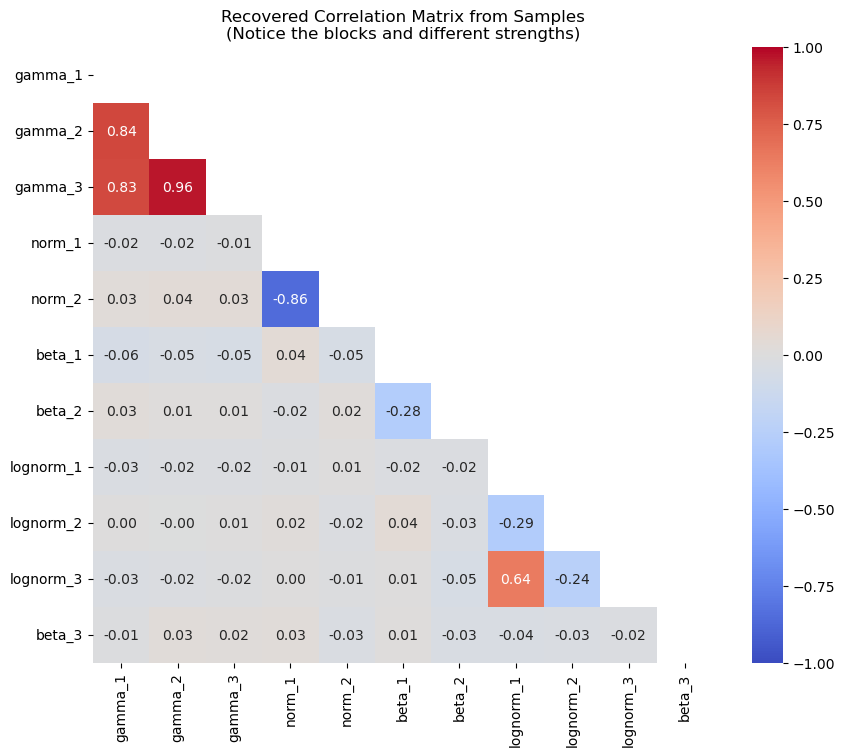


LogPDF of first point: -10.1744


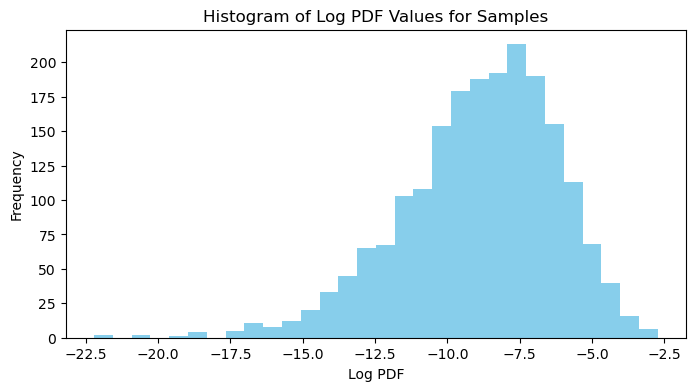

In [1]:
import numpy as np
import scipy.stats as stats
from scipy.stats import multivariate_normal, ortho_group
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class TunableCopulaSimulation:
    def __init__(self, seed=None):
        if seed:
            np.random.seed(seed)
        
        self.factors = []      
        self.total_dim = 0
        self.full_corr = None
        self.marginals = []
        
        # Metadata for naming
        self.var_names = [] 
        self._type_counters = {} # To track e.g., how many 'norm' vars we have

    def _generate_structured_correlation(self, dim, strength=None):
        """
        Generates a correlation matrix.
        If strength is None: Random structure.
        If strength is float (0.0 - 0.99): Controls tightness of correlation.
        """
        if dim == 1:
            return np.array([[1.0]])
        
        # Base: Random Orthogonal Matrix (Rotation)
        Q = ortho_group.rvs(dim)
        
        if strength is None:
            # Random eigenvalues between 0.5 and 2.0
            eig_vals = np.random.uniform(0.5, 2.0, size=dim)
        else:
            # Tunable Strength Logic:
            # High strength = High variance in eigenvalues (one large dominant direction)
            # strength 0.0 -> all eig_vals = 1 (Identity)
            # strength 0.9 -> one large eig_val, others small
            
            # Create a spectrum where one eigenvalue absorbs most variance based on strength
            # This mimics an 'Equicorrelated' structure rotated randomly
            base_val = 1.0 - strength
            peak_val = 1.0 + (dim - 1) * strength
            
            # Set first eigenvalue high, rest low
            eig_vals = np.full(dim, base_val)
            eig_vals[0] = peak_val
            
            # Add tiny jitter so it's not perfectly uniform
            eig_vals += np.random.normal(0, 0.01, size=dim)
            eig_vals = np.abs(eig_vals) # Ensure positive

        # Construct Covariance
        D = np.diag(eig_vals)
        cov = Q @ D @ Q.T
        
        # Normalize to Correlation Matrix (diagonal = 1)
        d_inv = np.diag(1.0 / np.sqrt(np.diag(cov)))
        corr = d_inv @ cov @ d_inv
        
        return corr

    def add_factor(self, dist_name, params, dim, corr_strength=None):
        """
        Args:
            dist_name (str): 'norm', 'gamma', 'beta', 'lognorm'
            params (list): List of dicts for parameters.
            dim (int): Dimension of this factor.
            corr_strength (float, optional): 0.0 (independent) to 0.99 (highly correlated).
                                             If None, randomized.
        """
        if len(params) != dim:
            raise ValueError(f"Length of params must match dim")

        # 1. Generate Correlation for this block
        corr_matrix = self._generate_structured_correlation(dim, strength=corr_strength)
        
        # 2. Build Marginals and Names
        factor_marginals = []
        
        for p in params:
            # Track naming (e.g., norm_1, norm_2)
            if dist_name not in self._type_counters:
                self._type_counters[dist_name] = 0
            self._type_counters[dist_name] += 1
            unique_name = f"{dist_name}_{self._type_counters[dist_name]}"
            self.var_names.append(unique_name)

            # Initialize Distribution
            if dist_name == 'norm':
                dist = stats.norm(**p)
            elif dist_name == 'gamma':
                dist = stats.gamma(**p)
            elif dist_name == 'beta':
                dist = stats.beta(**p)
            elif dist_name == 'lognorm':
                dist = stats.lognorm(**p)
            elif dist_name == 'expon':
                dist = stats.expon(**p)
            else:
                raise ValueError(f"Unknown dist: {dist_name}")
            factor_marginals.append(dist)

        self.factors.append({
            'corr': corr_matrix,
            'dim': dim,
            'strength': corr_strength
        })
        self.marginals.extend(factor_marginals)
        self.total_dim += dim
        self.full_corr = None # Reset build
        
        s_label = f"Strength={corr_strength}" if corr_strength is not None else "Random Strength"
        print(f"Added Factor [{dist_name}]: {dim} vars | {s_label}")

    def get_param_names(self):
        """
        Returns the list of variable names generated during construction.
        """
        return self.var_names

    def build(self):
        """Stitch the block diagonals together."""
        self.full_corr = np.eye(self.total_dim)
        curr = 0
        for f in self.factors:
            d = f['dim']
            self.full_corr[curr : curr+d, curr : curr+d] = f['corr']
            curr += d
            
    def sample(self, n_samples=1):
        if self.full_corr is None: self.build()
        
        # 1. Latent Gaussian Sample
        mvn = multivariate_normal(mean=np.zeros(self.total_dim), cov=self.full_corr)
        z = mvn.rvs(size=n_samples)
        if n_samples == 1: z = z.reshape(1, -1)
            
        # 2. Convert to Uniform (CDF)
        u = stats.norm.cdf(z)
        
        # 3. Convert to Marginals (PPF)
        x = np.zeros_like(u)
        for i, dist in enumerate(self.marginals):
            x[:, i] = dist.ppf(u[:, i])
            
        return x

    def logpdf(self, x):
        if self.full_corr is None: self.build()
        x = np.atleast_2d(x)
        
        log_marginals = np.zeros(x.shape[0])
        u_vals = np.zeros_like(x)
        
        # Marginal Log Likelihoods
        for i, dist in enumerate(self.marginals):
            log_marginals += dist.logpdf(x[:, i])
            u_vals[:, i] = dist.cdf(x[:, i])

        # Copula Log Likelihood
        z_vals = stats.norm.ppf(np.clip(u_vals, 1e-9, 1-1e-9))
        
        mvn = multivariate_normal(mean=np.zeros(self.total_dim), cov=self.full_corr)
        log_pdf_mvn = mvn.logpdf(z_vals)
        log_pdf_indep = np.sum(stats.norm.logpdf(z_vals), axis=1)
        
        return (log_pdf_mvn - log_pdf_indep) + log_marginals

# --- DEMONSTRATION ---

sim = TunableCopulaSimulation(seed=42)

# Factor 1: 3 Gamma variables, VERY STRONGLY correlated (0.95)
sim.add_factor(
    dist_name='gamma', dim=3, 
    params=[{'a':2}, {'a':3}, {'a':4}], # simplified params
    corr_strength=0.95 
)

# Factor 2: 2 Normal variables, WEAKLY correlated (0.1)
sim.add_factor(
    dist_name='norm', dim=2, 
    params=[{'loc':0, 'scale':1}, {'loc':10, 'scale':2}],
    corr_strength=0.99
)

# Factor 3: 2 Beta variables, MEDIUM correlation (0.6)
sim.add_factor(
    dist_name='beta', dim=2, 
    params=[{'a':2, 'b':2}, {'a':2, 'b':5}],
    corr_strength=0.3
)
# Factor 4: 1 LogNormal variables,
sim.add_factor(
    dist_name='lognorm', dim=3, 
    params=[{'loc':0, 's':1},{'loc':0, 's':1},{'loc':0, 's':1}],
    corr_strength=0.7
)
# Factor 5: 2 Beta variables, 
sim.add_factor(
    dist_name='beta', dim=1, 
    params=[{'a':3, 'b':2}],
    corr_strength=None
)
sim.build()

# 1. Get Names
print(f"\nParameter Names: {sim.get_param_names()}")

# 2. Sample
data = sim.sample(2000)
df = pd.DataFrame(data, columns=sim.get_param_names())

# 3. Verify Correlations with a Heatmap
plt.figure(figsize=(10, 8))
corr_obs = df.corr()

# Mask the upper triangle for cleaner view
mask = np.triu(np.ones_like(corr_obs, dtype=bool))
sns.heatmap(corr_obs, mask=mask, annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Recovered Correlation Matrix from Samples\n(Notice the blocks and different strengths)")
plt.show()

# 4. Evaluate LogPDF
pt = data[0]
print(f"\nLogPDF of first point: {sim.logpdf(pt)[0]:.4f}")


#plot log pdf
logpdf_values = sim.logpdf(data)
plt.figure(figsize=(8, 4))
plt.hist(logpdf_values, bins=30, color='skyblue')
plt.title("Histogram of Log PDF Values for Samples")
plt.xlabel("Log PDF")
plt.ylabel("Frequency")
plt.show()

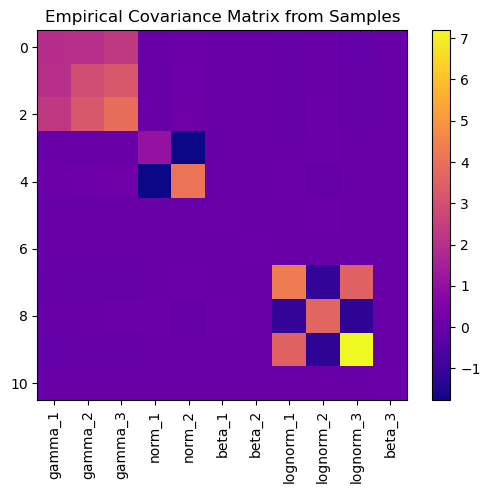

In [2]:
plt.imshow(np.cov(data, rowvar=False), cmap='plasma')
plt.xticks(ticks=np.arange(len(sim.get_param_names())), labels=sim.get_param_names(), rotation=90)
plt.colorbar()
plt.title("Empirical Covariance Matrix from Samples")
plt.show()

In [3]:
sim.get_param_names()

['gamma_1',
 'gamma_2',
 'gamma_3',
 'norm_1',
 'norm_2',
 'beta_1',
 'beta_2',
 'lognorm_1',
 'lognorm_2',
 'lognorm_3',
 'beta_3']

In [7]:
import morphZ as mz

samples = data
params = sim.get_param_names()
m_2 = mz.evidence(samples, logpdf_values,sim.logpdf,morph_type=f"4_group"
                  ,param_names=sim.get_param_names(),
                  output_path=f"{len(params)}_d")

tc_2 = mz.Nth_TC.compute_and_save_tc(samples,n_order=3,out_path=f"{len(params)}_d")


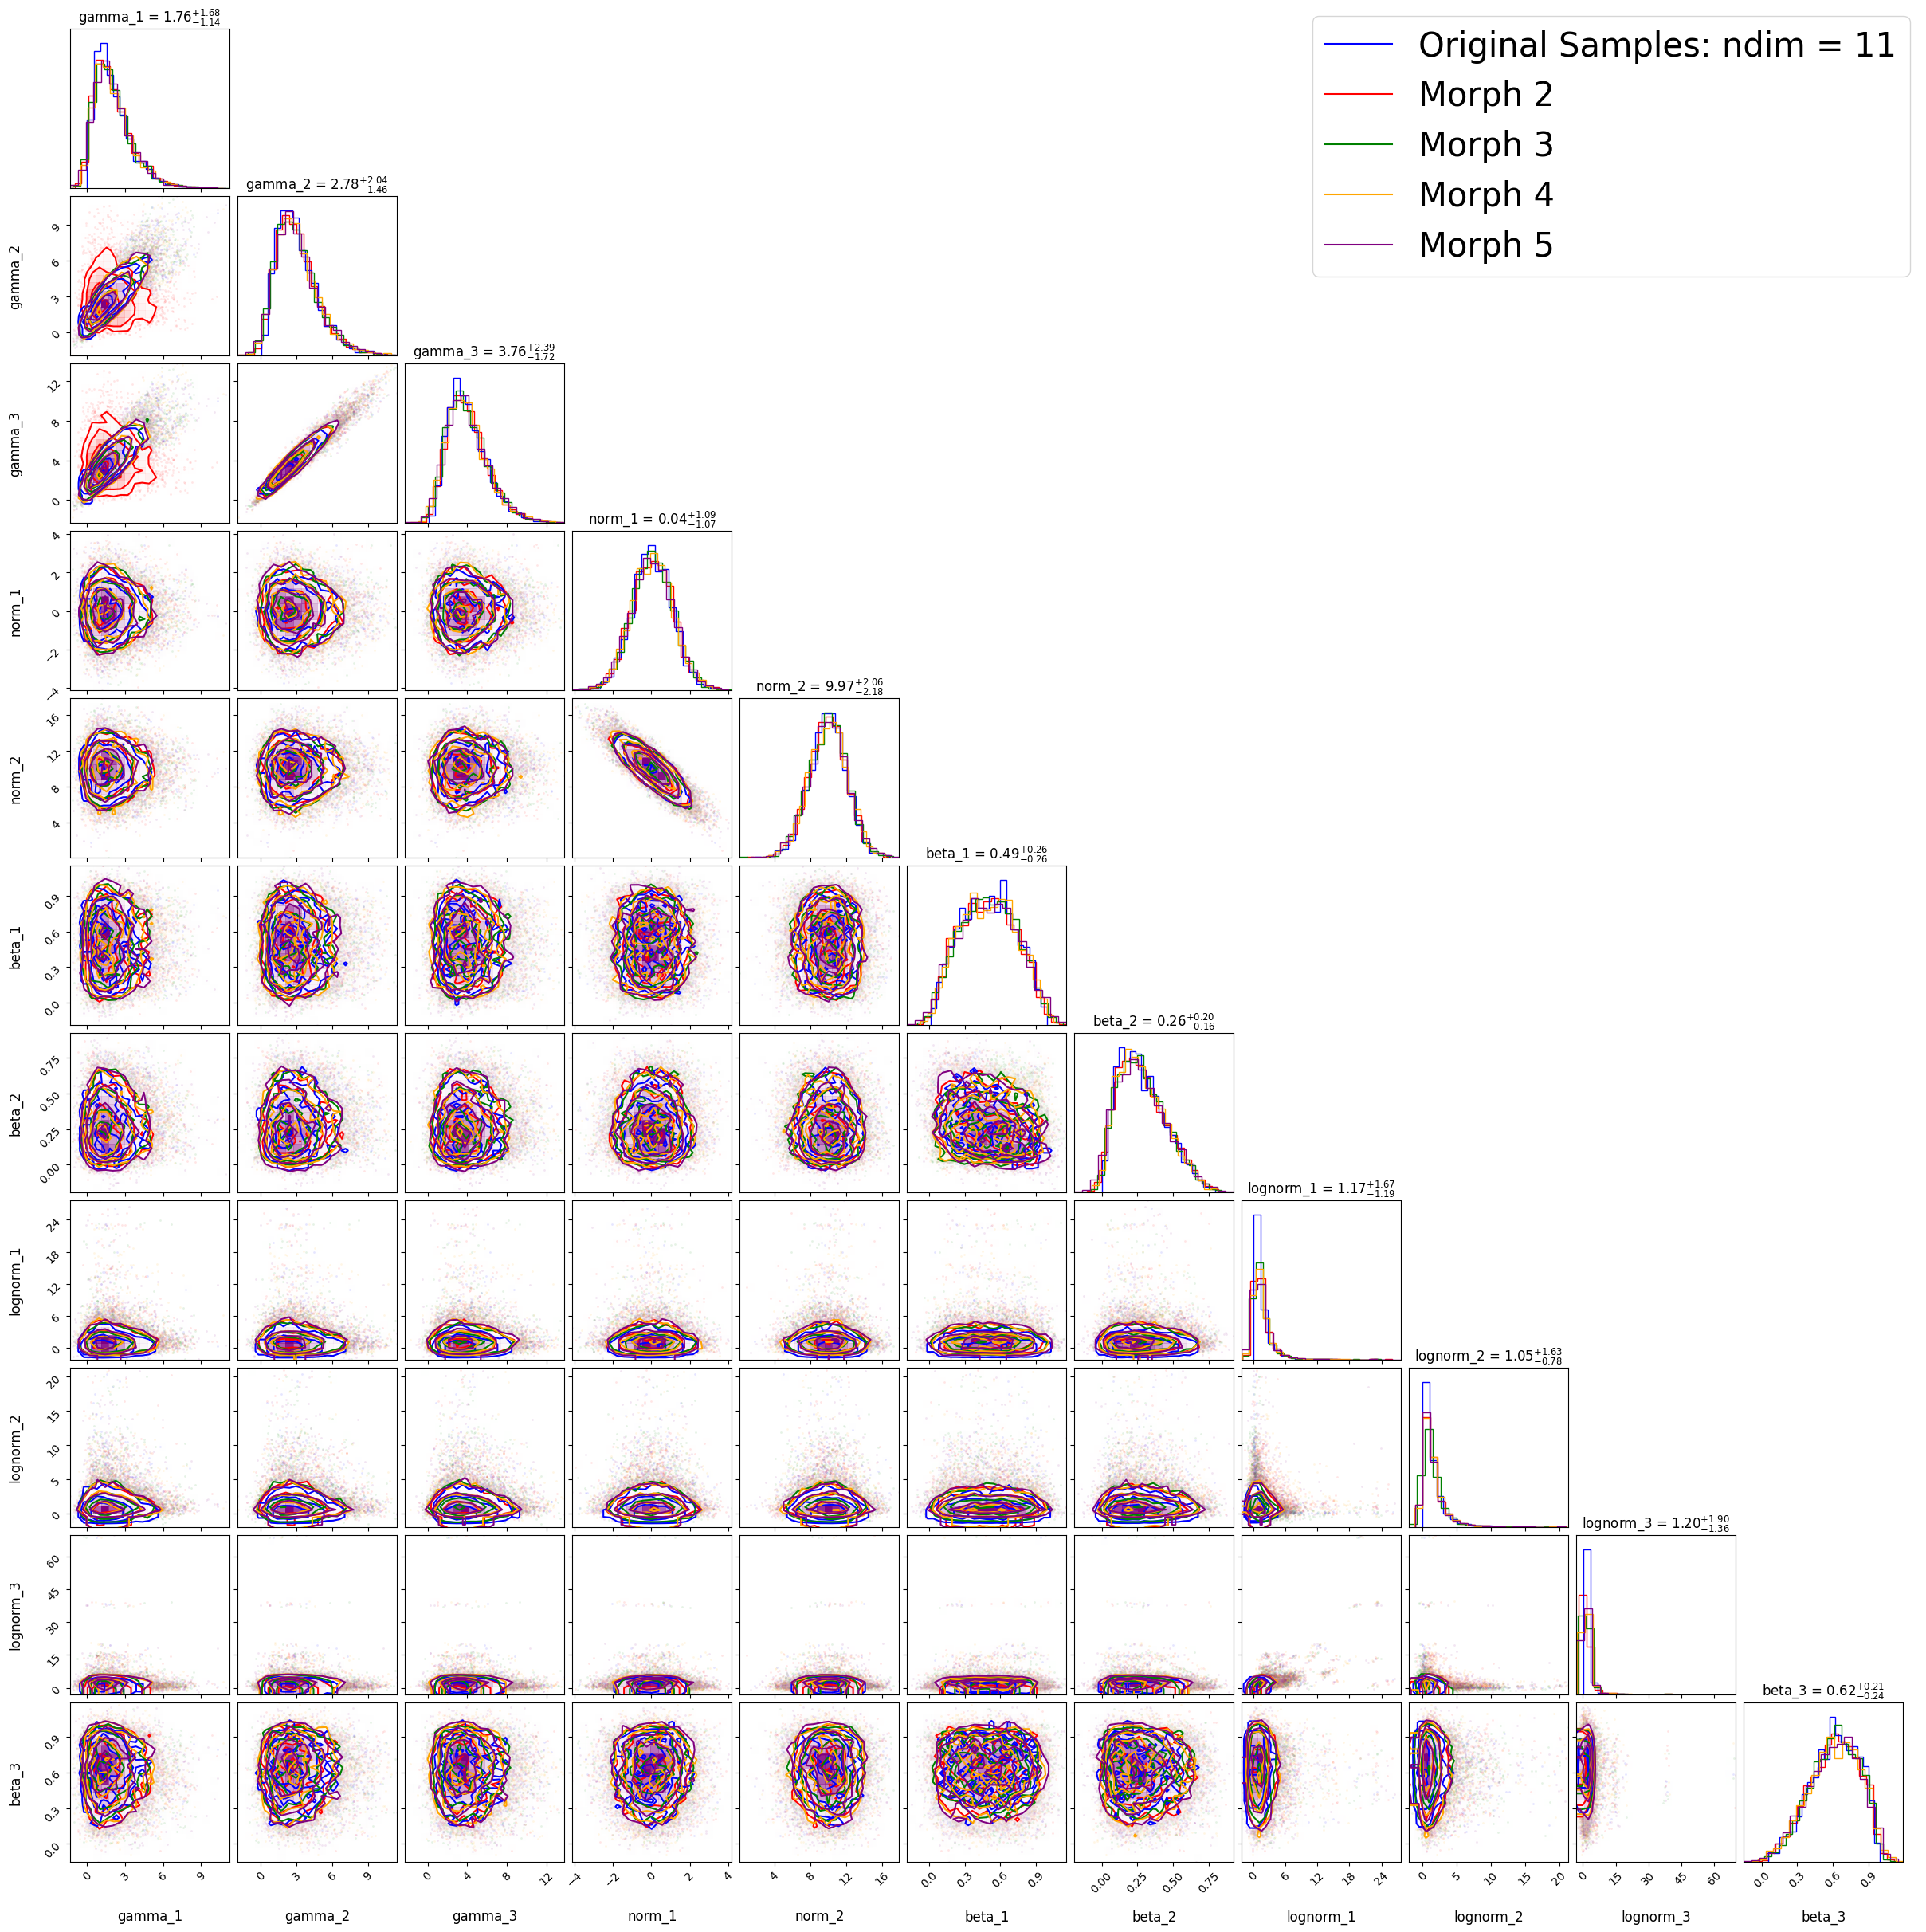

In [15]:
import pandas as pd
import corner
morph_2 = mz.GroupKDE(data,f"./{len(params)}_d/params_2-order_TC.json",param_names=sim.get_param_names())
morph_3 = mz.GroupKDE(data,f"./{len(params)}_d/params_3-order_TC.json",param_names=sim.get_param_names())
morph_4 = mz.GroupKDE(data,f"./{len(params)}_d/params_4-order_TC.json",param_names=sim.get_param_names())
morph_5 = mz.GroupKDE(data,f"./{len(params)}_d/params_5-order_TC.json",param_names=sim.get_param_names())
morph_2_samples = morph_2.resample(4000)
morph_3_samples = morph_3.resample(4000)
morph_4_samples = morph_4.resample(4000)
morph_5_samples = morph_5.resample(4000)
# corner plot morph_2_samples vs original samples
figure = corner.corner(morph_2_samples, labels=sim.get_param_names(), color='red',
                        label_kwargs={"fontsize": 12}, title_kwargs={"fontsize": 12},hist_kwargs={"density":True},
                          show_titles=True, title_fmt=".2f")
corner.corner(samples, labels=sim.get_param_names(),
                        fig=figure, color='blue', label_kwargs={"fontsize": 12},hist_kwargs={"density":True},
                        title_kwargs={"fontsize": 12}, show_titles=True, title_fmt=".2f")
corner.corner(morph_3_samples,labels=sim.get_param_names(),
               color='green', label_kwargs={"fontsize": 12}, title_kwargs={"fontsize": 12},hist_kwargs={"density":True},
                 show_titles=True, title_fmt=".2f", fig=figure)
corner.corner(morph_4_samples,labels=sim.get_param_names(),
               color='orange', label_kwargs={"fontsize": 12}, title_kwargs={"fontsize": 12},hist_kwargs={"density":True},
                 show_titles=True, title_fmt=".2f", fig=figure)
corner.corner(morph_5_samples,labels=sim.get_param_names(),
               color='purple', label_kwargs={"fontsize": 12}, title_kwargs={"fontsize": 12},hist_kwargs={"density":True},
                 show_titles=True, title_fmt=".2f", fig=figure)

plt.plot([],[],color='blue', label=f'Original Samples: ndim = {len(params)}')
plt.plot([],[],color='red', label='Morph 2')
plt.plot([],[],color='green', label='Morph 3')
plt.plot([],[],color='orange', label='Morph 4')
plt.plot([],[],color='purple', label='Morph 5')
figure.legend(loc='upper right', fontsize=30)
plt.show()

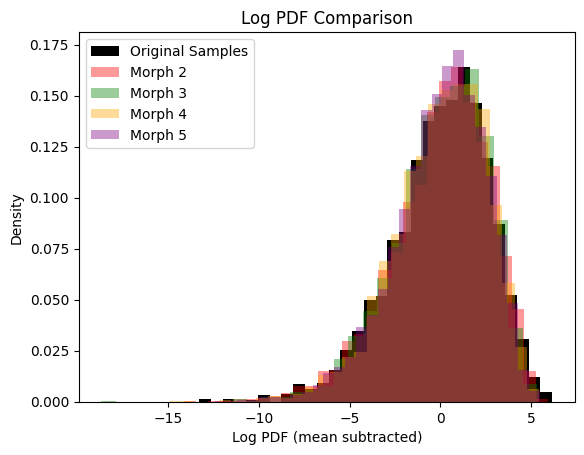

In [16]:
#plot different logpdf

morph_2_logpdf = morph_2.logpdf(morph_2_samples.T)
morph_3_logpdf = morph_3.logpdf(morph_3_samples.T)
morph_4_logpdf = morph_4.logpdf(morph_4_samples.T)
morph_5_logpdf = morph_5.logpdf(morph_5_samples.T)

plt.hist(logpdf_values-np.mean(logpdf_values),density=True, bins=30, color='black',label='Original Samples')
plt.hist(morph_2_logpdf-morph_2_logpdf.mean(),density=True, bins=30, color='red',alpha=0.4,label='Morph 2')
plt.hist(morph_3_logpdf-morph_3_logpdf.mean(),density=True, bins=30, color='green',alpha=0.4,label='Morph 3')
plt.hist(morph_4_logpdf-morph_4_logpdf.mean(),density=True, bins=30, color='orange',alpha=0.4,label='Morph 4') 
plt.hist(morph_5_logpdf-morph_5_logpdf.mean(),density=True, bins=30, color='purple',alpha=0.4,label='Morph 5')
plt.xlabel('Log PDF (mean subtracted)')
plt.ylabel('Density')
plt.title('Log PDF Comparison') 
plt.legend()
plt.show()